# ノートブック概要

本コンペで扱うデータに対しての説明を行う．今回はデータが大量にあるので，まずはどこに何のデータがあるのかを調査します．また，今回のデータはある程度用途が決まったファイルがあるようなので，そのようなファイルをそれぞれどう利用するのかについて確認していくことを目的とします．

## 目次

1. メタデータ
    - `[train/test]_adc_info.csv`
    - `train_labels.csv`
    - `axis_info.parquet`
    - `wavelength.csv`
2. シグナルデータ
    - `[train/test]/[planet_id]/AIRS-CH0_signal.parquet`
    - `[train/test]/[planet_id]/FGS1_signal.parquet`
3. キャリブレーション
    - `[train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/dark.parquet`
    - `[train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/dead.parquet`
    - `[train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/flat.parquet`
    - `[train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/linear_corr.parquet`
    - `[train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/read.parquet`

# 環境構築

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
BASE_PATH = "/kaggle/input/ariel-data-challenge-2024"

# メタデータ
## [train/test]_adc_info.csv

このデータはAIRS-CH0機器からの信号データ．各ファイルには，一定の時間ステップでキャプチャされた11,250行の画像データが格納されている．時間ステップの詳細は`axis_info.parquet`に記載されている．各32x356画像のデータは列としてフラット化されている．機器はデータをuint16(整数の16bit表現: 0~65535までの整数)として生成．ダイナミックレンジとして扱うためには`[train/test]_adc_info.csv`からのゲイン値を乗算し，オフセット値を追加する必要がある．

In [3]:
df_train_adc_info = pd.read_csv(os.path.join(BASE_PATH, "train_adc_info.csv"), index_col="planet_id")
df_test_adc_info = pd.read_csv(os.path.join(BASE_PATH, "test_adc_info.csv"), index_col="planet_id")
df_train_adc_info.head()

,FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain,star
planet_id,,,,,
785834,-343.335938,0.837244,-778.916533,0.924746,1
14485303,-366.381992,0.842983,-740.323212,0.931727,1
17002355,-386.107037,1.041701,-808.690659,1.513541,0
24135240,-339.737490,0.840239,-776.124167,0.931277,1
25070640,-355.660433,1.041280,-848.371494,1.503923,0


| 名前 | 説明 |
| - | - |
| FGS | FGS1 はAriel の Fine Guidance System (FGS) の最初のチャネル |
| AIRS | AIRS-CH0は、アリエル赤外線分光計（AIRS）の最初のチャネル（CH0） |
| offset | イメージセンサに入射した光子によって発生した電流を何倍に増幅するかを示すパラメータ |
| gain | 画像信号がゼロやマイナスにならないように信号に一定の値を加える調整 |
| star | 恒星のインデックス |

## train_labels.csv
正解ラベル．学習データにおける予測対象のデータ．このデータはシミュレーションから作成されており，完全な真の値になっている．

In [4]:
df_train_label = pd.read_csv(os.path.join(BASE_PATH, "train_labels.csv"), index_col="planet_id")
df_train_label.head()

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
planet_id,,,,,,,,,,,,,,,,,,,,,
785834,0.001086,0.001137,0.001131,0.001124,0.001138,0.001131,0.001123,0.001127,0.001120,0.001116,...,0.001075,0.001076,0.001076,0.001076,0.001074,0.001073,0.001072,0.001073,0.001073,0.001072
14485303,0.001835,0.001835,0.001834,0.001833,0.001833,0.001833,0.001833,0.001834,0.001834,0.001835,...,0.001893,0.001892,0.001892,0.001891,0.001891,0.001891,0.001890,0.001890,0.001889,0.001888
17002355,0.002792,0.002814,0.002808,0.002804,0.002809,0.002805,0.002802,0.002805,0.002801,0.002797,...,0.002784,0.002783,0.002783,0.002783,0.002783,0.002784,0.002784,0.002785,0.002785,0.002784
24135240,0.001294,0.001308,0.001308,0.001306,0.001306,0.001303,0.001306,0.001314,0.001314,0.001314,...,0.001405,0.001404,0.001403,0.001402,0.001401,0.001400,0.001399,0.001397,0.001395,0.001393
25070640,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,...,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988


## axis_info.parquet
FGSとAIRSそれぞれの計器の軸情報

In [5]:
df_train_axis_info = pd.read_parquet(os.path.join(BASE_PATH, "axis_info.parquet"))
df_train_axis_info.head()

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
0,0.000028,4.078463,0.1,0.000028
1,0.000056,4.074023,4.5,0.000056
2,0.001361,4.069568,0.1,0.000139
3,0.001389,4.065100,4.5,0.000167
4,0.002694,4.060618,0.1,0.000250


## wavelength.csv
データセット内の各グラウンドトゥルーススペクトルの波長グリッド

In [6]:
df_wave_length = pd.read_csv("/kaggle/input/ariel-data-challenge-2024/wavelengths.csv")
df_wave_length.head()

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
0,0.705,1.951761,1.960612,1.96945,1.978273,1.987083,1.995879,2.004661,2.01343,2.022184,...,3.84972,3.85481,3.859887,3.86495,3.869999,3.875034,3.880055,3.885063,3.890056,3.895036


# シグナルデータ
シグナルデータセットは２つの別々の危機から時系列画像と較正データで構成．FGSの主な役割は，衛星の中心合わせ，焦点合わせ，誘導を可能にすることであるが，可視スペクトル内のターゲット星の高精度測光も提供．感度は0.60 ~ 0.80 μm．AIRS-CH0は，Ariel赤外線分光計（AIRS）の最初のチャンネル．1.95 ~ 3.90 μmの感度を持つ赤外線分光計で分解能は約R=100．プロセスによってFGS1用に135,000フレーム，AIRS-CH0用に11,250フレームが生成されます．

Ariel詳細：https://sci.esa.int/web/ariel/-/ariel-definition-study-report-red-book

## [train/test]/[planet_id]/AIRS-CH0_signal.parquet
AIRS-CH0機器から得られたデータ．各ファイルは一定の時間ステップで記録されたデータが11,250行分与えられている．詳細は`axis_info.csv`に記載されている．

In [7]:
planet_id = "1044371083"

df_airs_ch0_signal = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/AIRS-CH0_signal.parquet"))
df_airs_ch0_signal.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_11382,column_11383,column_11384,column_11385,column_11386,column_11387,column_11388,column_11389,column_11390,column_11391
0,700,708,721,740,708,697,717,729,717,712,...,700,697,728,730,712,705,706,710,710,714
1,711,712,702,731,712,708,704,707,703,712,...,694,711,717,719,709,706,712,729,703,688
2,705,706,712,707,691,709,718,697,701,696,...,734,723,694,694,691,718,727,720,715,723
3,719,703,700,705,704,731,706,729,703,716,...,724,718,725,709,733,700,712,728,714,712
4,700,698,718,691,721,690,718,702,698,715,...,697,727,724,718,722,711,706,701,708,713


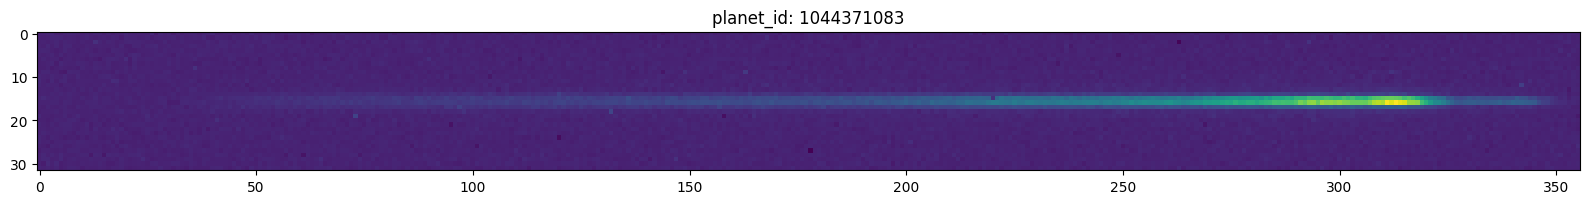

In [8]:
dat = df_airs_ch0_signal.values.reshape([11250, 32, -1])
fig, ax = plt.subplots(figsize=(dat.shape[1]//2, dat.shape[2]//2))
ax.imshow(dat[0])
ax.set_title(f"planet_id: {planet_id}")
plt.tight_layout()
plt.show()

In [9]:
# plot_scale = 2

# # frames = dat.shape[0]
# frames = 10
# fig = plt.figure(figsize=(dat.shape[1]//plot_scale,
#                           dat.shape[2]//plot_scale))
# def func(i):
#     plt.cla()
#     plt.imshow(dat[i])
#     plt.axis("off")
# anim = fa(fig, func, interval=100, frames=range(frames))
# anim.save("test.mp4", writer="ffmpeg", dpi=80,
#           savefig_kwargs=dict(bbox_inches='tight', pad_inches=.1))
# plt.close()

# path = "/kaggle/working/test.mp4"
# mp4 = open(path, "rb").read()
# url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""<video height=400 controls><source src="%s" type="video/mp4"></video>""" % url)

## [train/test]/[planet_id]/FGS1_signal.parquet
FGS1機器から取得したシグナルデータ．各ファイルは0.1秒の時間ステップで記録された135,000行のデータが格納されている．各行は1024個の列を持ち，それぞれの値は32x32のピクセル値に対応しているので整形することで画像データとして扱うことが出来る．オリジナルデータを復元するには，`[train/test]_adc_inf.csv`に書かれている対応した`gain`を掛け，`offset`の値を足し合わせることで得られる．

In [10]:
df_fgs1_signal = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/FGS1_signal.parquet"))
df_fgs1_signal.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1014,column_1015,column_1016,column_1017,column_1018,column_1019,column_1020,column_1021,column_1022,column_1023
0,304,321,323,317,318,319,304,317,308,304,...,297,299,318,314,300,297,297,287,310,300
1,304,316,292,299,313,316,332,311,317,332,...,299,292,319,307,322,298,326,252,328,306
2,313,311,308,310,273,318,302,312,302,316,...,285,312,330,305,313,301,314,324,301,299
3,307,306,323,294,289,309,295,300,303,345,...,298,312,306,319,319,302,297,289,311,300
4,327,309,290,301,308,308,319,318,340,332,...,303,310,286,304,301,290,311,326,297,319


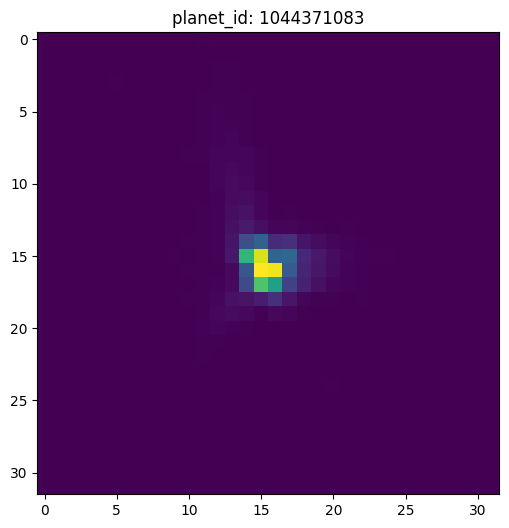

In [11]:
dat = df_fgs1_signal.values.reshape(-1, 32, 32)
fig, ax = plt.subplots(figsize=(dat.shape[1]//5, dat.shape[2]//5))
ax.imshow(dat[0])
ax.set_title(f"planet_id: {planet_id}")
plt.show()

# キャリブレーション
キャリブレーションデータは電子機器の特性を記録している．このデータを使って画像データの信号対ノイズ比率を計算するために利用出来る．

キャリブレーションの参考サイト：https://practicalastrophotography.com/a-brief-guide-to-calibration-frames/

## [train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/dark.parquet
シャッターが閉じた状態で撮影された露出で、センサーの熱ノイズとバイアスレベルを捕捉．暗電流の減算に利用する．

In [12]:
df_airs_ch0_calib_dark = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/AIRS-CH0_calibration/dark.parquet"))
df_fgs1_calib_dark = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/FGS1_calibration/dark.parquet"))

In [13]:
print(df_airs_ch0_calib_dark.shape)
df_airs_ch0_calib_dark.head()

(32, 356)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_346,column_347,column_348,column_349,column_350,column_351,column_352,column_353,column_354,column_355
0,0.002631,0.004631,0.007843,0.005743,0.006579,0.008634,0.008349,0.009547,0.005511,0.007241,...,0.005483,0.006560,0.004738,0.006680,0.000046,0.005376,0.006717,0.005135,0.008020,0.008054
1,0.006559,0.006199,0.006218,0.007462,0.007295,0.006725,0.003810,0.007651,0.007959,0.007601,...,0.004852,0.005247,0.006438,0.005943,0.004788,0.006611,0.007538,0.007815,0.005931,0.006373
2,0.008799,0.007865,0.008126,0.006470,0.005720,0.006880,0.007013,0.006162,0.006225,0.007796,...,0.005863,0.005052,0.007325,0.006267,0.005181,0.003640,0.005517,0.005002,0.006952,0.007825
3,0.008385,0.008998,0.003310,0.006102,0.005054,0.006870,0.007788,0.007931,0.005145,0.007253,...,0.008889,0.006118,0.006146,0.006921,0.005927,0.008809,0.007091,0.003897,0.007079,0.005988
4,0.007083,0.005939,0.006704,0.006564,0.007039,0.006098,0.008293,0.006383,0.005493,0.005305,...,0.006036,0.006435,0.005909,0.007521,0.005939,0.005681,0.006236,0.004225,0.006665,0.006998


In [14]:
print(df_fgs1_calib_dark.shape)
df_fgs1_calib_dark.head()

(32, 32)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31
0,0.007876,0.009286,0.008641,0.007131,0.006437,0.008419,0.007501,0.008474,0.007674,0.007584,...,0.005962,0.008971,0.005181,0.004601,0.006126,0.008850,0.005930,0.006833,0.008012,0.008513
1,0.004560,0.006931,0.006341,0.008246,0.006663,0.006278,0.008440,0.007527,0.007482,0.005634,...,0.005491,0.005767,0.009288,0.006506,0.006735,0.007584,0.009197,0.005915,0.008105,0.005995
2,0.008706,0.005163,0.007834,0.005371,0.006414,0.006545,0.007596,0.007439,0.007873,0.006670,...,0.007044,0.008850,0.005719,0.006152,0.006720,0.006897,0.006308,0.007629,0.005945,0.009095
3,0.008054,0.006483,0.008824,0.005384,0.006126,0.008162,0.008860,0.007181,0.008265,0.008679,...,0.005020,0.005524,0.006377,0.007182,0.006280,0.007261,0.007922,0.009058,0.005845,0.007433
4,0.008928,0.006284,0.007309,0.007561,0.005759,0.005408,0.008504,0.008173,0.006458,0.007840,...,0.007913,0.008537,0.005967,0.007739,0.008141,0.007774,0.006675,0.007736,0.005974,0.007840


## [train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/dead.parquet
センサー上のデッドピクセルとホットピクセルを識別．デッドピクセルは光に反応しないがホットピクセルは入射光に関係なく常に高い信号レベルを生成．

In [15]:
df_airs_ch0_calib_dead = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/AIRS-CH0_calibration/dead.parquet"))
df_fgs1_calib_dead = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/FGS1_calibration/dead.parquet"))

In [16]:
print(df_airs_ch0_calib_dead.shape)
df_airs_ch0_calib_dead.head()

(32, 356)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_346,column_347,column_348,column_349,column_350,column_351,column_352,column_353,column_354,column_355
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
print(df_fgs1_calib_dead.shape)
df_fgs1_calib_dead.head()

(32, 32)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## [train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/flat.parquet
均一に照らされた表面を画像化することによって作成．これを利用することでピクセル間の感度のばらつきや光学システムの不規則性を補正するのに利用できる

In [18]:
df_airs_ch0_calib_flat = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/AIRS-CH0_calibration/flat.parquet"))
df_fgs1_calib_flat = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/FGS1_calibration/flat.parquet"))

In [19]:
print(df_airs_ch0_calib_flat.shape)
df_airs_ch0_calib_flat.head()

(32, 356)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_346,column_347,column_348,column_349,column_350,column_351,column_352,column_353,column_354,column_355
0,0.989592,0.985490,1.018283,1.013448,1.029490,1.014518,0.990675,0.981534,0.995583,0.997485,...,1.016280,0.994982,1.001593,1.005999,1.007070,1.010341,0.991454,1.014635,1.020585,0.996841
1,1.027112,0.995082,1.005234,1.019437,1.000213,1.008855,0.951177,1.012721,1.002430,1.005324,...,1.024930,1.013591,0.987825,1.017992,0.988862,1.003103,1.014007,1.017646,0.980544,1.003148
2,1.025022,1.015159,0.985766,1.008367,0.995286,1.000649,1.093324,1.013806,0.993234,1.005211,...,0.997997,1.000230,1.008049,1.000538,1.023111,0.981728,0.985330,1.004717,0.995221,1.004042
3,1.034653,1.004706,0.993056,1.003189,1.004536,0.984348,0.991892,0.991890,1.014422,1.014044,...,1.007905,1.013738,0.996307,0.988091,1.022719,1.022899,0.979331,0.982327,1.006285,1.006630
4,1.014871,0.991775,1.006086,1.008805,1.013521,0.999769,1.025979,1.000993,0.997275,1.012366,...,1.009128,0.977642,0.996901,0.986530,1.006928,1.006218,1.014695,1.004686,1.010185,1.008486


In [20]:
print(df_fgs1_calib_flat.shape)
df_fgs1_calib_flat.head()

(32, 32)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31
0,0.997860,0.962451,0.961502,0.989516,0.999851,0.961565,0.952677,0.975687,0.968179,0.977839,...,0.958037,0.998171,0.990756,0.968416,0.984514,0.982550,0.980615,0.982607,0.974026,0.981340
1,0.970354,1.004747,0.985391,0.976922,0.976474,0.976855,0.992090,0.968567,0.991203,0.992048,...,0.969612,0.994231,0.991616,0.992380,0.980585,0.983966,0.967015,0.959391,0.967339,0.991937
2,0.992739,0.968327,0.993804,0.997802,0.963763,0.986486,0.977272,0.988415,0.980887,0.944801,...,0.985624,0.982388,0.977127,0.992800,0.976796,0.971641,0.982915,0.982594,0.984881,0.968378
3,0.973250,0.987143,0.987185,0.976465,0.981161,0.972531,0.994839,0.990555,0.982418,0.980196,...,0.964535,0.993199,0.983030,0.979941,0.971089,0.980676,0.982323,0.959462,1.000776,0.959420
4,0.966114,0.984108,0.982774,0.990635,0.983254,0.978337,0.980472,0.982030,0.983974,0.975165,...,0.981562,0.967368,0.997294,0.969573,0.971606,0.969654,0.992294,0.978002,0.956287,0.975245


## [train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/linear_corr.parquet
センサーの直線性補正に関する情報．検出器のピクセルの応答は，電子が満たされるにつれて直線性が低下し，飽和点に近づくが，そこに達するとそれ以上電子を収集できなくなり，光に対する応答は平坦になる．信号を正確に推定する為には，受診電荷の関数としての機器の応答が較正され，n次多項式を使用して補正が計算される．この多項式を用いることで，ピクセルによって収集・測定された電子の数を，検出器が直線尾打尾で生成した電子の数に変換可能

In [21]:
df_airs_ch0_calib_line_corr = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/AIRS-CH0_calibration/linear_corr.parquet"))
df_fgs1_calib_line_corr = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/FGS1_calibration/linear_corr.parquet"))

In [22]:
print(df_airs_ch0_calib_line_corr.shape)
df_airs_ch0_calib_line_corr.head()

(192, 356)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_346,column_347,column_348,column_349,column_350,column_351,column_352,column_353,column_354,column_355
0,0.248328,0.236796,0.212122,0.040992,0.223036,0.260050,0.016634,-0.000924,0.428047,-0.019349,...,0.266843,-0.117015,0.052902,0.114524,-0.035507,0.023253,0.216919,0.119479,0.156251,0.190873
1,0.224294,0.255628,-0.143775,0.337747,0.159871,0.415546,-0.136227,0.144800,0.255573,0.088033,...,-0.148464,0.133849,0.257714,-0.066555,0.193450,0.298501,-0.016142,0.021362,0.069558,0.088609
2,0.050083,0.336646,0.128319,-0.171756,-0.067246,0.098830,0.115266,0.027763,0.113083,-0.006670,...,-0.091795,-0.040872,0.182636,0.132079,-0.033384,-0.074861,0.064957,0.253487,-0.088853,0.340319
3,0.303297,0.224126,-0.054458,0.090729,-0.167400,0.091622,0.150912,0.107014,0.149268,0.128610,...,-0.135179,0.069282,0.099852,0.392160,0.034994,0.039516,0.133951,0.009193,0.431392,0.369417
4,-0.084765,0.084017,0.207549,-0.182390,0.005540,-0.082728,0.122660,-0.053386,-0.273070,-0.076328,...,0.420759,0.384988,0.212268,-0.045317,-0.040971,0.134304,0.160306,-0.011387,0.230867,0.358674


In [23]:
print(df_fgs1_calib_line_corr.shape)
df_fgs1_calib_line_corr.head()

(192, 32)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31
0,0.253710,0.000134,0.376480,0.207456,0.380616,0.229986,0.281868,0.300195,0.281150,0.170209,...,0.357206,0.447277,0.301437,0.076099,0.354140,0.299568,0.292119,0.250388,0.298726,0.337536
1,0.298263,0.371464,0.132593,0.358952,0.260589,0.321208,0.408291,0.395074,0.550074,0.268406,...,0.296138,0.495719,0.198122,0.354189,0.312393,0.415651,0.476386,0.245855,0.139103,0.365613
2,0.162025,0.291415,0.285340,0.206682,0.287018,0.081756,0.404172,0.234360,0.422325,0.556141,...,0.277907,0.245087,0.388784,0.284693,0.099782,0.114403,0.478170,0.335322,0.330255,0.275096
3,0.374324,0.342129,0.536896,0.293181,0.409347,0.418978,0.282301,0.526111,0.235587,0.291597,...,0.227082,0.339717,0.144829,0.325912,0.406593,0.205174,0.410869,0.301707,0.450111,0.309122
4,0.313737,0.220756,0.312432,0.287723,0.272013,0.233293,0.385696,0.172365,0.356823,0.271926,...,0.287762,0.348057,0.192476,0.357631,0.531933,0.321874,0.315878,0.441360,0.386461,0.301966


## [train/test]/[planet_id]/[AIRS-CH0/FGS1]_calibration/read.parquet
読み取りノイズフレーム．センサーの読み取りプロセスの中に発生する電子ノイズをキャプチャ．このノイズは，検出器に光が当たっていない場合でも存在する．

In [24]:
df_airs_ch0_calib_read = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/AIRS-CH0_calibration/read.parquet"))
df_fgs1_calib_read = pd.read_parquet(os.path.join(BASE_PATH, f"train/{planet_id}/FGS1_calibration/read.parquet"))

In [25]:
print(df_airs_ch0_calib_read.shape)
df_airs_ch0_calib_read.head()

(32, 356)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_346,column_347,column_348,column_349,column_350,column_351,column_352,column_353,column_354,column_355
0,12.995339,12.495758,12.631591,15.058141,13.124151,15.313447,12.304253,14.830727,13.007769,12.559774,...,13.069724,13.145781,12.660957,13.953925,12.257952,13.181958,12.796944,13.262446,12.810003,12.556107
1,13.276866,13.500076,14.975392,13.183601,14.855815,13.160477,12.728657,12.738680,12.672219,12.948373,...,12.998441,13.472873,13.289257,13.554357,13.402775,12.707373,13.238138,13.512214,12.474109,12.615316
2,12.656122,13.105853,12.409562,12.792006,13.638007,12.825556,12.549460,13.198838,14.846630,13.707326,...,12.599929,13.821584,12.819470,13.040169,12.479429,12.199233,13.436445,13.325440,13.869907,13.002572
3,13.768372,12.998867,13.926691,14.344555,13.248324,18.096345,13.270988,16.774429,14.028419,13.469063,...,14.221303,13.784987,12.944599,12.533899,12.989509,12.827852,13.644878,14.151639,13.099649,13.316888
4,12.760439,16.908862,12.632662,13.194869,12.850266,12.770953,12.784867,14.519577,12.970542,13.523994,...,12.708626,12.645419,12.675835,12.528301,13.326929,12.621270,13.118501,12.854125,12.891273,13.137809


In [26]:
print(df_fgs1_calib_read.shape)
df_fgs1_calib_read.head()

(32, 32)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31
0,13.447132,13.037364,13.320732,13.934092,14.160968,12.997231,13.605174,13.179105,13.031221,13.514571,...,12.830434,13.167031,12.889489,13.446304,13.519172,13.556801,13.398178,12.817820,12.855377,13.383958
1,12.799192,15.720345,12.893337,13.209815,13.018760,12.853811,14.092373,28.917124,14.327434,12.952086,...,13.051660,13.315811,12.645670,13.236526,12.655067,13.625855,15.532673,13.316868,13.065052,13.007496
2,14.011855,14.344862,13.188338,14.408124,13.020654,13.505918,12.732587,12.829406,12.820350,13.804098,...,13.279897,13.659994,12.731043,14.440821,13.113338,12.870840,13.968151,15.748286,13.902305,12.735503
3,13.223301,13.600391,12.934800,17.042988,15.969407,46.141069,13.909606,13.255826,14.416834,12.676454,...,12.976551,12.928398,13.247288,13.112748,13.768122,13.077388,13.206464,12.941768,13.240524,12.603768
4,12.462461,32.868870,13.565033,12.948105,13.117695,13.190062,13.625904,12.907982,14.176126,14.645302,...,13.271953,13.048486,14.321457,17.067648,13.212197,13.434782,13.049322,13.067504,12.892875,12.835842
